<div style="background-color:	#345783; text-align:center; vertical-align: middle; padding:40px 0; margin-top:30px">
<h1 style="color:white">Deep Learning - Huisprijzen voorspellen</h1>
<b style="color:black"> Kaggle: Yoyoyoghurt(teamnaam), JortAkershoek, juliaboschman, Sam Keesen </b>
   
<b style="color:white"> Jort Akershoek, Julia Boschman, Sam Keesen</b>
    </div>

<a name='start'></a>

## Table of contents

1. [H1: Inleiding](#1.0)
2. [H2: EDA](#2.0)
    - [&sect;2.1: EDA DataFrame](#2.1)
    - [&sect;2.2: EDA Foto's](#2.2)
    - [&sect;2.3: Conclusie EDA](#2.3)
3. [H3: Fully-connected neuraal netwerk](#3.0)
    - [&sect;3.1: Het model](#3.1)
    - [&sect;3.2: Modelarchitectuur](#3.2)
    - [&sect;3.3: Keuzes voor het model](#3.3)
    - [&sect;3.4: Loss function en optimizer kiezen](#3.4)
    - [&sect;3.5: Het model compilen](#3.5)
    - [&sect;3.6: Visualisatie Loss](#3.6)
4. [H4: Convolutioneel neuraal netwerk](#4.0)
5. [H5: Transfer Learning](#5.0)
    - [&sect;5.1: Het model](#5.1)
    - [&sect;5.2: Modelarchitectuur](#5.2)
6. [H6: Multimodaal model](#6.0)
7. [H7: Bevindingen](#7.0)
    - [&sect;7.1: Samenvatting uitkomsten](#7.1)
8. [H8: Conclusie en aanbevelingen](#8.0)
    - [&sect;8.1: Uitdagingen modeleringsproces](#8.1)
    - [&sect;8.2: Prestaties modelarchitecturen](#8.2)
    - [&sect;8.3: Advies aan makelaar](#8.3)
    - [&sect;8.4: Advies aan huizen(ver)koper](#8.4)
9. [H9: Literatuurlijst](#9.0)

In [1]:
# Alle nodige imports
import os
import pydot
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from efficientnet.tfkeras import EfficientNetB0 
from tensorflow.keras import Sequential, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV2, InceptionV3, DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Om de modelarchitecturen te kunnen zien maken we gebruik van een library die nog geïnstalleerd moest worden op de laptops. Dat gebeurt hieronder, dus als deze library nog niet up jullie laptop staat kan het worden geïnstalleerd met de code hieronder. De cel weer daaronder verwijst naar de locatie waar de Graphviz in is gedownload. Als deze niet gedownload is op de laptop zal de plot ook niet gemaakt kunnen worden. Ook wordt efficientnet geinstalleerd wat later gebruikt wordt voor een transfer model.

In [2]:
#!pip install --user pydot graphviz
#!pip install --user efficientnet

In [2]:
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

[Back to the top](#start)
<a name='1.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H1: Inleiding</strong></h2>
</div>

Voor het vak Deep Learning wordt er in dit portfolio onderzoek gedaan naar de werking en toepassing van verschillende vormen van neurale netwerken. De opdracht voor dit portfolio is het voorspellen van huisprijzen van huizen in Amerika met de hulp van neurale netwerken. Dit kunnen neurale netwerken zijn die alleen maar werken met tabulaire data, juist alleen met foto data of zelfs met beide. Er worden 4 verschillende neurale netwerken gebruikt in dit notebook en dat zijn als volgt:
- Fully-connected neuraal netwerk, alleen tabulaire data.
- Convolutioneel neuraal netwerk, alleen foto data.
- Transfer Learning, alleen foto data.
- Multimodaal model, zowel tabulaire als foto data.

Aan het einde van het notebook gaan wij reflecteren op de manier(en) die het beste resultaat heeft geleverd voor ons vraagstuk. Hier zal worden gekeken naar het model, maar ook wat de reden zou kunnen zijn dat het model beter werkt dan de andere.

[Back to the top](#start)
<a name='2.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H2: EDA</strong></h2>
</div>

<a name='2.1'></a>
<h3>&sect;2.1: EDA DataFrame</h3>

In [3]:
train = pd.read_csv("train.csv")
train.head()

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
0,1,4,4.0,4053,33.6968,-111.8892,869500
1,2,4,3.0,3343,34.8280,-119.0349,865200
2,3,3,4.0,3923,33.7669,-111.9182,889000
3,4,5,5.0,4022,33.7752,-111.7791,910000
4,5,3,4.0,4116,33.7669,-111.9182,971226


Als eerst gaan wij een EDA uitvoeren op de data die wij verkregen hebben voor dit project. Het gaat om twee verschillende soorten data. Er zijn zowel foto's als tabulaire data beschikbaar. Als eerst wordt er gekeken naar de tabulaire data.

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   500 non-null    int64  
 1   Bedrooms   500 non-null    int64  
 2   Bathrooms  500 non-null    float64
 3   Area       500 non-null    int64  
 4   Latitude   500 non-null    float64
 5   Longitude  500 non-null    float64
 6   Price      500 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 27.5 KB


De kolommen bevatten het volgende:
- House ID: Het huis ID wat koppelt aan de ID's die aan de foto's verbonden zijn. Zo kan de target kolom toegevoegd worden aan de foto's.
- Bedrooms: Het aantal slaapkamers die er te vinden zijn in het huis.
- Bathrooms: Het aantal badkamers die er te vinden zijn in het huis.
- Area: Het totale oppervlakte wat hoort bij het huis.
- Latitude: De breedtegraad van het huis op de wereldkaart.
- Longitude: De hoogtegraad van het huis op de wereldkaart. Met deze en latitude wordt dus ook bepaald op welke locatie het huis zich bevindt.
- Price: Dit is de target kolom, de kolom die uiteindelijk voorspeld moet worden. Hierin staan de prijzen van de huizen.

In [6]:
train.isna().sum()

House ID     0
Bedrooms     0
Bathrooms    0
Area         0
Latitude     0
Longitude    0
Price        0
dtype: int64

In [7]:
train.describe()

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
count,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,5.000000e+02
mean,250.500000,3.350000,2.669500,2369.64600,35.128844,-116.469049,5.980218e+05
std,144.481833,1.172283,1.017578,1208.18261,2.386173,6.554434,5.240649e+05
min,1.000000,1.000000,1.000000,701.00000,32.631500,-122.368300,2.200000e+04
25%,125.750000,2.000000,2.000000,1440.00000,33.808200,-119.802500,2.350000e+05
50%,250.500000,3.000000,2.500000,2097.50000,33.920800,-117.609600,5.300000e+05
75%,375.250000,4.000000,3.000000,3104.50000,35.640600,-116.371300,7.490000e+05
max,500.000000,10.000000,7.000000,9583.00000,47.791800,-87.885900,5.858000e+06


Het train DataFrame
1. Het is een Dataframe
2. Het heeft geen missende waardes
3. Alle kolommen zijn numeriek

In [8]:
test = pd.read_csv("test.csv")
test.head()

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
0,501,3,2.0,2330,35.6406,-120.7003
1,502,3,2.5,1339,35.6406,-120.7003
2,503,3,2.0,1472,35.6406,-120.7003
3,504,4,4.0,2681,35.6406,-120.7003
4,505,3,2.5,1935,33.8085,-117.9228


Nadat er een kleine check is gedaan naar de inhoud van het "train" DataFrame wordt er een snelle check uitgevoerd op de test dataset. Dit wordt gedaan om te kijken of de data gebruikt kan worden om te testen. Zo mag het geen missende waardes bevatten en moet het overeenkomen met de train data zonder de "Price" kolom.

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   House ID   35 non-null     int64  
 1   Bedrooms   35 non-null     int64  
 2   Bathrooms  35 non-null     float64
 3   Area       35 non-null     int64  
 4   Latitude   35 non-null     float64
 5   Longitude  35 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 1.8 KB


In [10]:
test.describe()

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude
count,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000
mean,518.000000,3.771429,2.600000,2297.171429,36.631043,-120.662114
std,10.246951,0.910259,0.591608,1457.127886,1.837672,1.670038
min,501.000000,2.000000,1.500000,987.000000,33.808500,-121.775800
25%,509.500000,3.000000,2.000000,1580.000000,34.724550,-121.775800
50%,518.000000,4.000000,2.500000,2012.000000,37.965800,-121.775800
75%,526.500000,4.000000,3.000000,2387.500000,37.965800,-119.311550
max,535.000000,7.000000,4.000000,9536.000000,37.965800,-117.922800


In [11]:
test.isna().sum()

House ID     0
Bedrooms     0
Bathrooms    0
Area         0
Latitude     0
Longitude    0
dtype: int64

Het test DataFrame
1. Het is een DataFrame
2. Het heeft geen missende waardes
3. Alle kolommen zijn numeriek

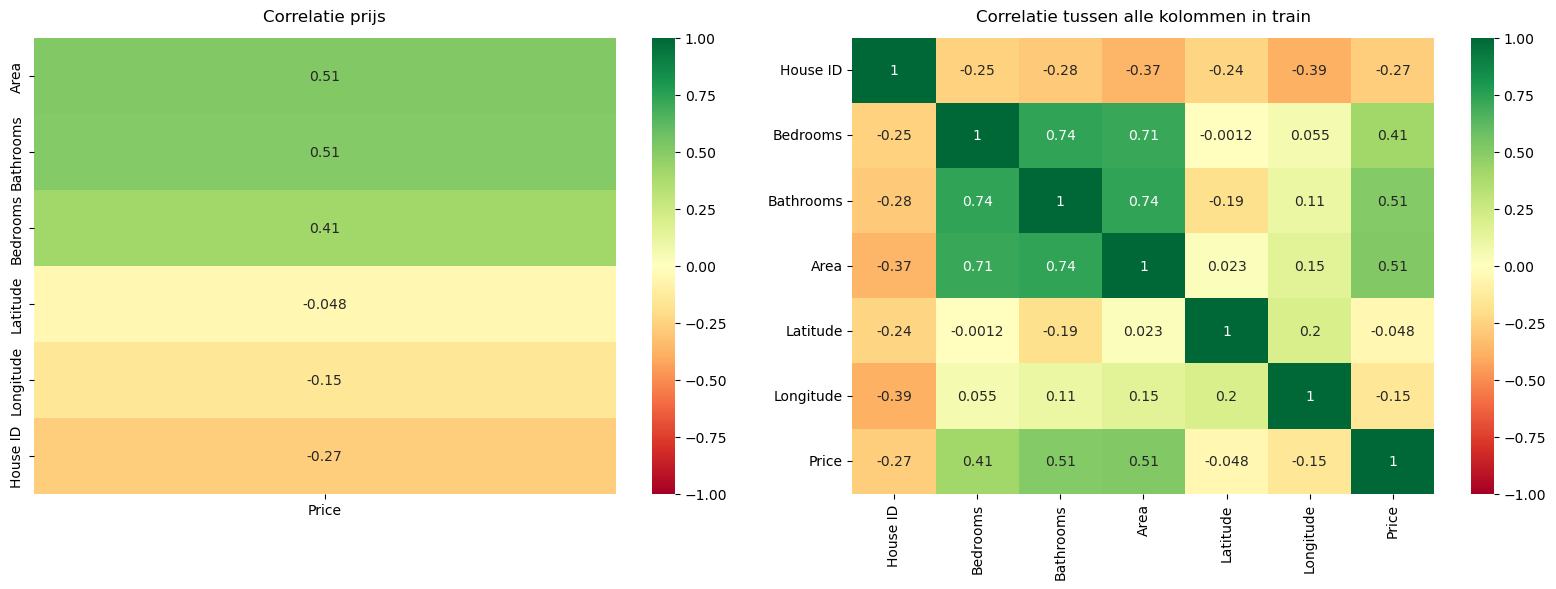

In [12]:
plt.figure(figsize=(16, 6))
plt.subplot(121)  
heatmap1 = sns.heatmap(train.corr(method='pearson')[['Price']].drop("Price").sort_values(by='Price', ascending=False),
                       vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap1.set_title('Correlatie prijs', fontdict={'fontsize': 12}, pad=12)


plt.subplot(122) 
heatmap2 = sns.heatmap(train.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='RdYlGn')
heatmap2.set_title('Correlatie tussen alle kolommen in train', fontdict={'fontsize': 12}, pad=12)

plt.tight_layout()  
plt.show()

We zien in de heatmaps hierboven dat er een aantal kolommen zijn die wat meer invloed hebben op het voorspellen van de huisprijzen. Zo hebben de kolom "Area", "Bathrooms" en "Bedrooms" de meeste invloed. Ook zien we dat er een hoge correlatie is tussen de kolommen "Bathrooms" en "Bedrooms" en tussen de kolommen "Area" en "Bedrooms". Dit zijn voor ons dus belangrijke kolommen om te gebruiken voor ons latere Deep Learning model.

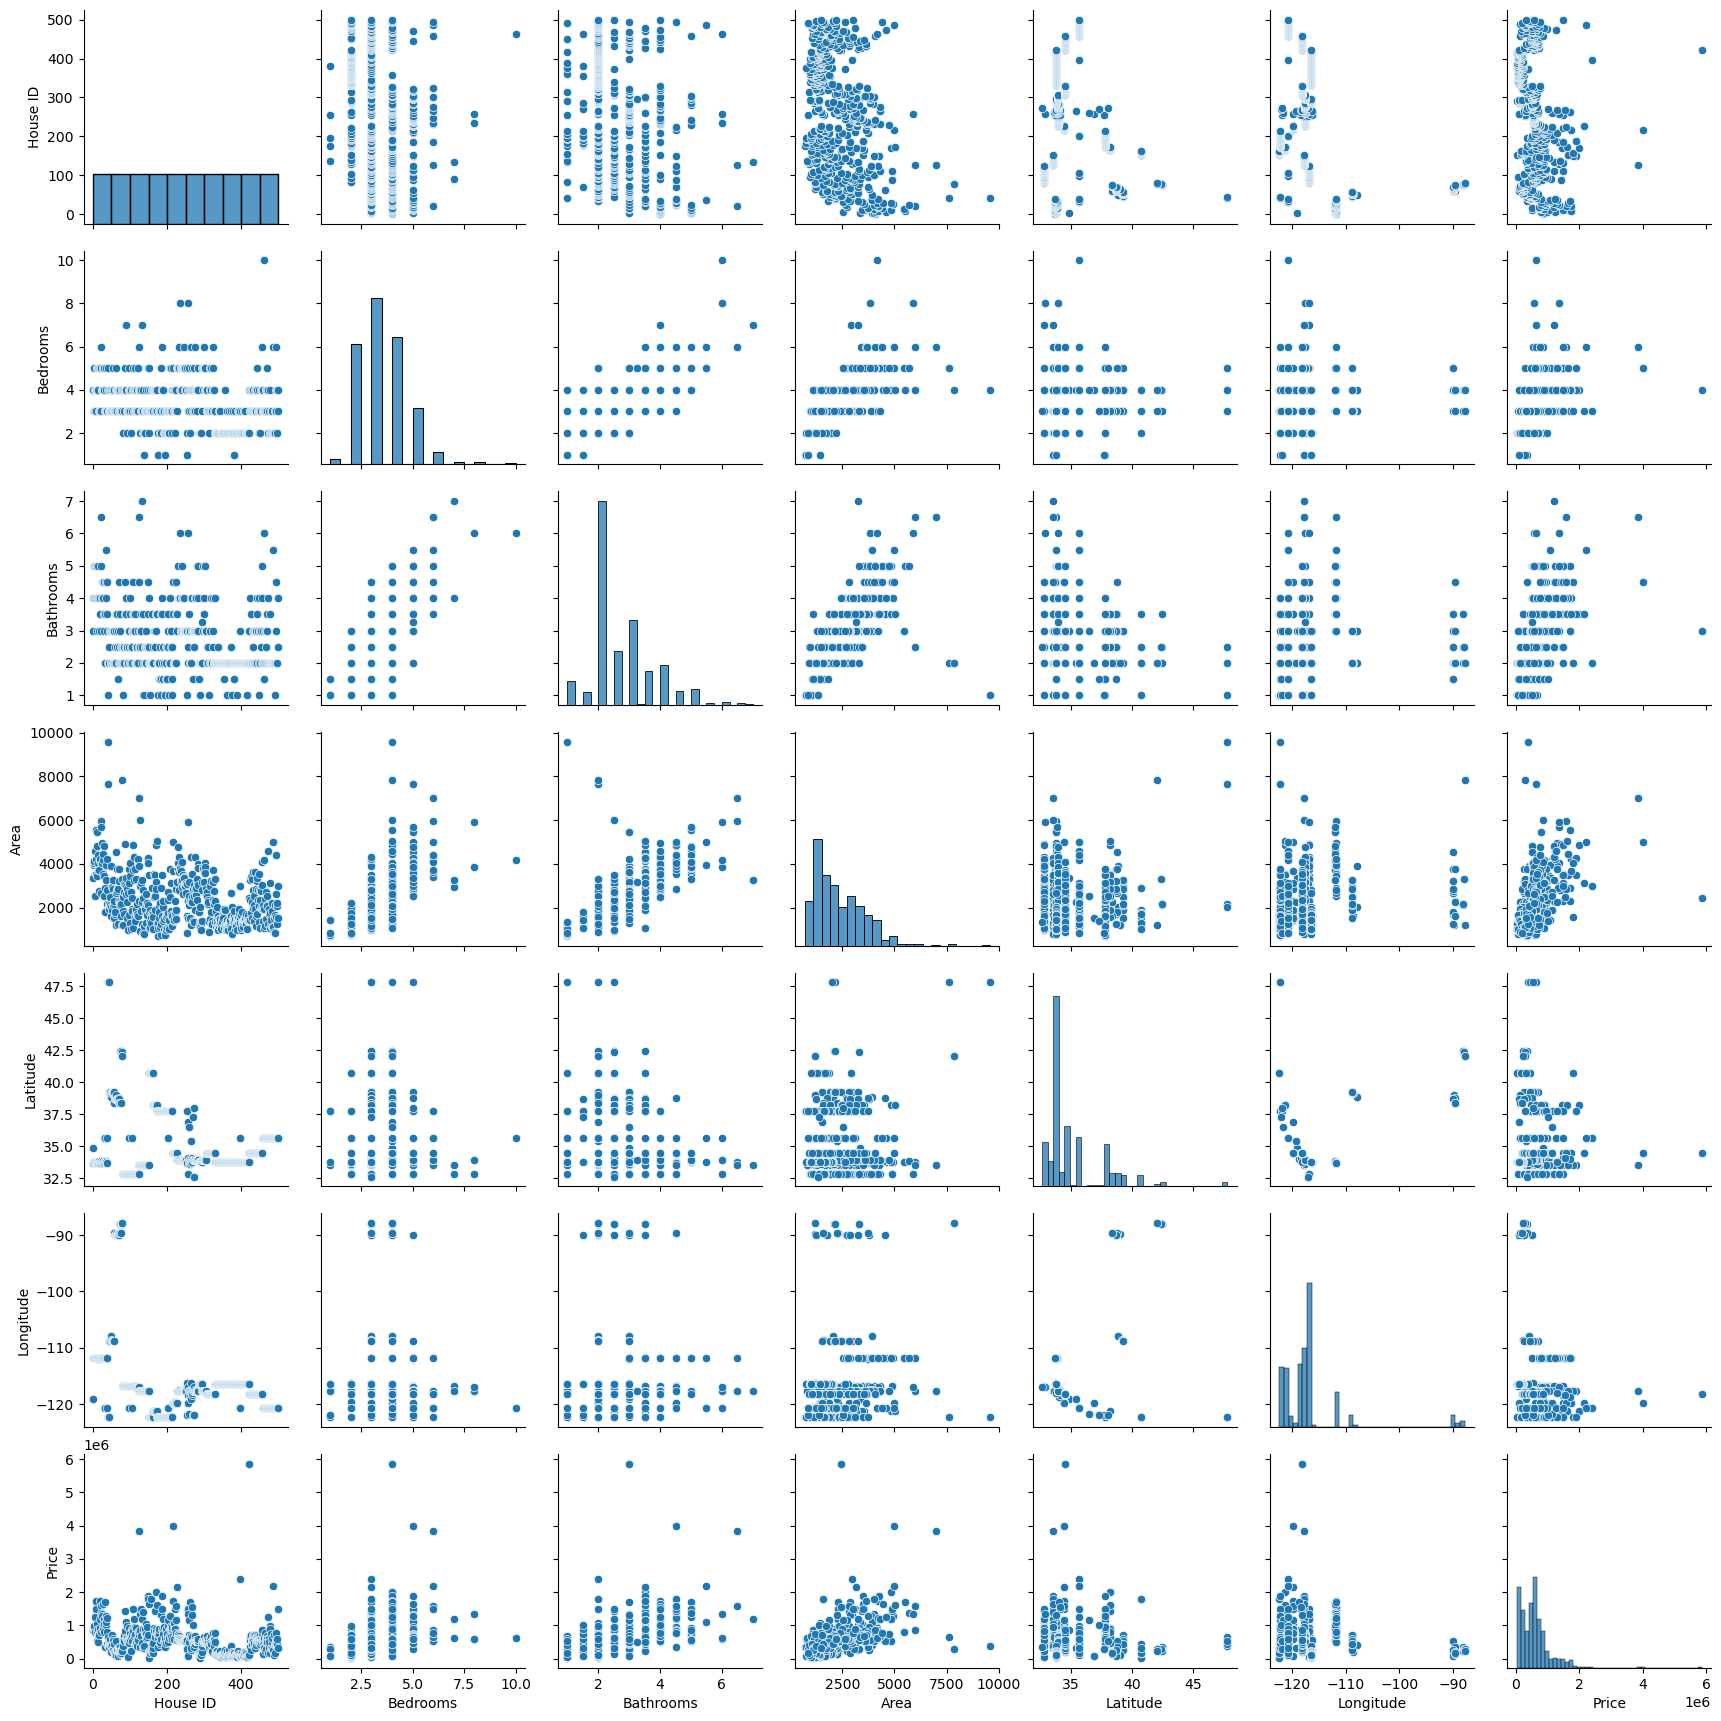

In [13]:
sns.pairplot(train)
plt.show()

Hierboven geven we een visualisatie van de correlaties tussen alle individuele kolommen. Hier zien wij weer de sterkste correlatie terug tussen de drie kolommen "Area", "Bedrooms" en "Bathrooms".

We gaan nu wat dieper kijken naar een aantal kolommen om te kijken naar mogelijke uitschieters.

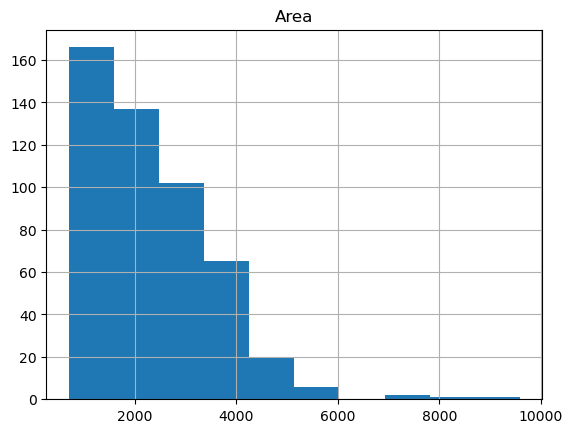

In [14]:
train.hist("Area")
plt.show()

We zien enkele uitschieters wanneer wij kijken naar de "Area" kolom. Wanneer wij de regels weergeven van de huizen met een oppervlakte van hoger dan 6000 vinden wij 4 huizen. Wij zien hier dat het grootste huis helemaal niet duur is. Het huis is nog net geen 4 ton, maar heeft wel een oppervlakte van bijna 10.000 square feet.

In [15]:
train[train["Area"] > 6000]

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
40,41,4,1.0,9583,47.7918,-122.2243,395000
41,42,5,2.0,7627,47.7918,-122.2243,638940
78,79,4,2.0,7841,42.0467,-87.8859,299000
125,126,6,6.5,7000,33.5145,-117.7084,3850000


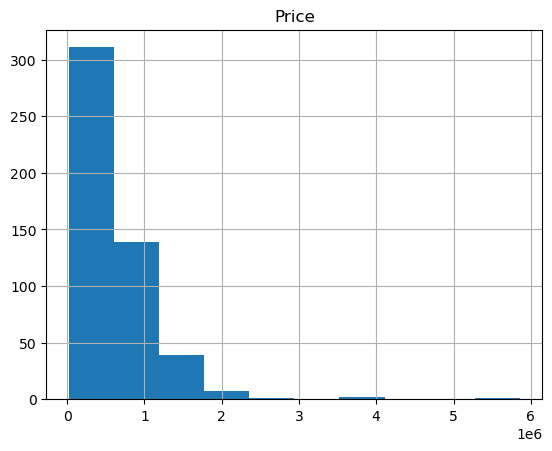

In [16]:
train.hist("Price")
plt.show()

Ook vinden wij een paar hoge uitschieters bij de "Price" kolom. Wanneer wij gaan kijken naar de rijen die hierbij horen valt het op dat het huis met de hoogste prijs van bijna 6 miljoen helemaal niet zo'n groot oppervlakte heeft. Dit valt op, vooral omdat wij net hebben gezien dat het grootste huis die 4 keer kleiner is wel 15 keer duurder is. Het zou te maken kunnen hebben met de ligging, dus dat gaan wij later verder onderzoeken.

In [17]:
train[train["Price"] > 3000000]

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
125,126,6,6.5,7000,33.5145,-117.7084,3850000
216,217,5,4.5,5000,34.4453,-119.8025,4000000
421,422,4,3.0,2454,34.4835,-118.1959,5858000


Ook nemen wij een kijkje naar de huizen die meer dan 6 slaapkamers hebben. Dit zijn er maar een aantal en de oppervlaktes liggen dicht bij elkaar. Wat wel opvalt is de prijzen die erg uiteen liggen.

In [18]:
train[train["Bedrooms"] > 6]

,House ID,Bedrooms,Bathrooms,Area,Latitude,Longitude,Price
89,90,7,4.0,2929,32.8282,-116.7543,625000
133,134,7,7.0,3265,33.5145,-117.7084,1200000
234,235,8,6.0,3849,33.9208,-117.6096,580000
256,257,8,6.0,5900,32.8562,-116.9201,1350000
461,462,10,6.0,4188,35.6406,-120.7003,629000


Aan het begin van onze EDA hebben wij gezien dat er een aantal kolommen het meeste invloed hebben op het voorspellen van de huisprijs. Deze gaan wij wat beter bekijken door naar de groepsgemiddeldes te kijken.

In [19]:
bedrooms = train.groupby("Bedrooms")["Price", "Area"].mean()
bedrooms

C:\Users\bosch\AppData\Local\Temp\ipykernel_6120\382465525.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bedrooms = train.groupby("Bedrooms")["Price", "Area"].mean()


,Price,Area
Bedrooms,,
1,2.828180e+05,909.400000
2,2.326775e+05,1303.196721
3,5.980077e+05,2045.183432
4,7.887358e+05,2970.038760
5,8.186575e+05,3775.263158
6,1.180959e+06,4399.538462
7,9.125000e+05,3097.000000
8,9.650000e+05,4874.500000
10,6.290000e+05,4188.000000


Het valt ons op dat de oppervlaktes van de huizen veelal toenemen hoe meer slaapkamers er aanwezig zijn. Bij de prijs is dit een ander geval. Wij zien het geleidelijk toenemen tot hij zijn maximum heeft bereikt bij 6 slaapkamers. Hier telt hij een gemiddelde prijs van wel 1 miljoen. Hierna neemt het weer af.

In [20]:
train["Bedrooms"].value_counts()

3     169
4     129
2     122
5      57
6      13
1       5
7       2
8       2
10      1
Name: Bedrooms, dtype: int64

Wanneer wij kijken naar de aantallen die voorkomen met meer dan 6 slaapkamers zien wij dat er aan veel kleiner aantal aan huizen is. Daarom is het niet betrouwbaar om deze te serieus te nemen tijdens het voorspellen van de prijs, omdat er bijvoorbeeld 1 huis is met 10 slaapkamers en 0 huizen met 9 slaapkamers.

In [21]:
bathrooms = train.groupby("Bathrooms")["Price", "Area"].mean()
bathrooms

C:\Users\bosch\AppData\Local\Temp\ipykernel_6120\533526990.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bathrooms = train.groupby("Bathrooms")["Price", "Area"].mean()


,Price,Area
Bathrooms,,
1.00,3.608495e+05,1323.750000
1.50,5.223000e+05,1346.846154
2.00,3.371919e+05,1640.338164
2.50,6.214254e+05,2286.727273
3.00,6.996374e+05,2770.383721
3.25,5.150000e+05,3149.000000
3.50,1.066022e+06,3284.771429
4.00,8.905609e+05,3619.170732
4.50,1.367707e+06,4168.857143


Wij doen het zelfde voor de "Bathroom" kolom. Hierin stijgt ook de oppervlaktes van de huizen na mate er meer badkamers aanwezig zijn. De prijs is echter redelijk instabiel. Ook is het gemiddelde niet heel betrouwbaar, omdat de data niet goed verdeeld is. Zo zijn er 207 huizen met 2 badkamers en maar 3 huizen met 6 badkamers. Dit is waarschijnlijk dan ook het geval dat er niet veel huizen zijn met zo veel badkamers.

In [22]:
train["Bathrooms"].value_counts()

2.00    207
3.00     86
2.50     55
4.00     41
3.50     35
1.00     24
5.00     16
4.50     14
1.50     13
6.00      3
6.50      2
5.50      2
7.00      1
3.25      1
Name: Bathrooms, dtype: int64

Het valt ons op dat er ook halve waardes zijn voor de kolom "Bathrooms". Wij gaan er van uit dat dit badkamers zijn waar alleen een WC aanwezig is.

<a name='2.2'></a>
<h3>&sect;2.2: EDA Foto's</h3>

In [19]:
img_directory = "Train"
image_size = (1024, 1024)
batch_size = 4

image_dataset = tf.keras.utils.image_dataset_from_directory(
    img_directory,
    label_mode=None,
    image_size=image_size,
    batch_size=batch_size
)

image_file_paths = image_dataset.file_paths
image_hids = [Path(image_file_path).stem for image_file_path in image_file_paths]
image_hids_int = [int(house_id) for house_id in image_hids]

labels = [train.loc[train['House ID'] == houseid, 'Price'].values for houseid in image_hids_int]
labels_dataset = tf.data.Dataset.from_tensor_slices(labels).batch(batch_size)
final_dataset = tf.data.Dataset.zip((image_dataset, labels_dataset))

Found 500 files belonging to 1 classes.


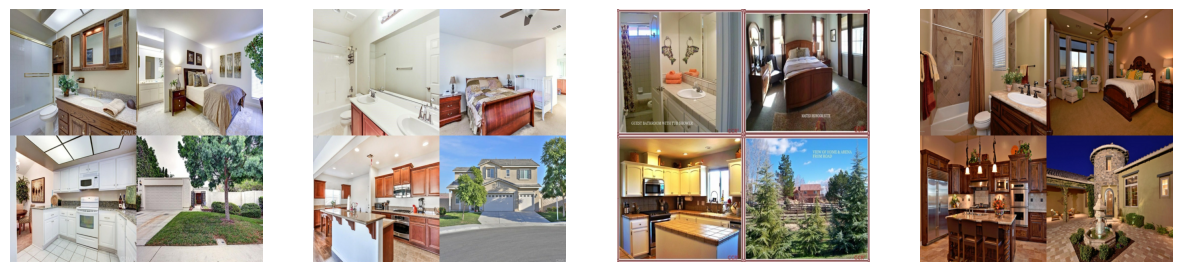

In [20]:
image_iterator = iter(image_dataset)
batch_images = next(image_iterator)

num_images_to_display = 4

plt.figure(figsize=(15, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(batch_images[i].numpy().astype("uint8"))
    plt.axis("off")
plt.show()

<a name='2.3'></a>
<h3>&sect;2.3: Conclusie EDA</h3>

Na het uitvoeren van de EDA wordt het duidelijk dat het een lastige opdracht gaat worden. Van een heleboel huizen blijkt dat er uitschieters aanwezig zijn. Zo zijn er veel grote huizen die niet heel duur zijn of hele kleine huizen die wel erg duur zijn. Alle gegevens geven niet meteen een goede indicatie van de prijs die gekoppeld is aan het huis. 

Wel weten we nu van een aantal kolommen dat ze belangrijk zijn. Zo is de Area kolom en de Bathroom kolom het meeste waarde toevoegen aan het voorspellen van de prijs. Bij beide kolommen zagen we in de grafieken een positieve correlatie. 

Nu moeten er heel wat modellen getraind worden om op goede resultaten uit te komen. Zoals eerder vermeld zijn er wel een hoop uitschieters in de data waardoor er een kans is dat de modellen nooit heel goed gaan worden. Er zijn vaak meer redenen waarom een woning een bepaalde prijs heeft, en het kan dat deze redenen niet zijn opgenomen in de data. 

[Back to the top](#start)
<a name='3.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H3: Fully-connected neuraal netwerk</strong></h2>
</div>


<a name='3.1'></a>
<h2>&sect;3.1: Het model</h2>

In [5]:
X = train.drop(columns=["Price"])
y = train["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
input_shape = X_train.shape[1]

model = Sequential()
model.add(Dense(128, activation="relu", input_shape=(input_shape,)))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="relu"))

<a name='3.2'></a>
<h2>&sect;3.2: Model architectuur</h2>

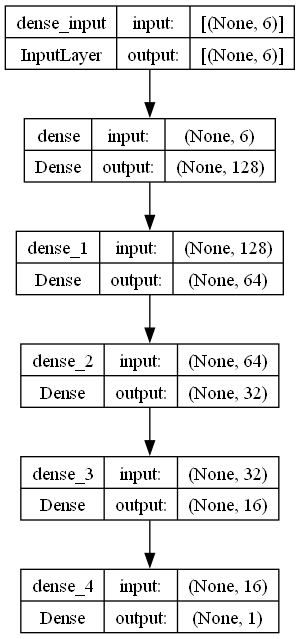

In [7]:
tf.keras.utils.plot_model(model, to_file='fully_connected.png', show_shapes=True, show_layer_names=True)

<a name='3.3'></a>
<h2>&sect;3.3: Keuzes voor het model</h2>

Om een fully connected neuraal netwerk te maken is het belangrijk om de lagen zo op te stellen dat iedere laag een veelvoud is van 2. Ook kan het goed werken om in de eerst volgende laag de helft van de waarde van de laag erboven te pakken. Daarom hebben wij er voor gekozen om het aantal lagen met het aantal neuronen te pakken. Door de vier "Hidden layers" geven we het model tijd om goede keuzes te maken. 

Voor iedere laag gebruiken we de ReLU functie, de Rectified Linear Unit. Wat de ReLU functie doet is, hij maakt iedere input positief. Wanneer een input positief is, blijft deze positief. Wanneer een input negatief is wordt deze 0. Er is iets bijzonders aan de ReLU functie, want hij doet zich eigenlijk voor als een lineaire functie, maar in werkelijheid is dit niet zo. Reden dat we hebben gekozen voor dit model zijn dan ook dat het inputs naar 0 brengt in tegenstelling tot de sigmoid functie die inputs rond de 0 kan brengen. Ook is een neuraal netwerk vaak beter te optimaliseren wanneer er sprake is van lineairiteit. Een neuraal netwerk wordt gebruikt voor complexe vraagstukken, dus vaak ontbreekt er lineairiteit in de data. De ReLU functie kan er voor zorgen dat deze dicht naar lineair gaan. Als laatste is het ook de meest efficiënte functie, omdat het een duidelijke threshold heeft. Hierdoor kan het model ook vaak sneller worden getraind. (Brownlee, 2020)

Om uiteindelijk het model te moeten trainen is het belangrijk dat er een waarde wordt gekozen voor het aantal epochs om het model voor te laten runnen. Wij hebben er voor gekozen om te beginnen bij 1000000000 epochs. Op deze manier kunnen we kijken naar de verandering van de losses om te kijken of er in de laatste paar epochs nog veel verandering is. Door het toepassen van early stopping wordt het duidelijk bij welke epoch het model het beste presteert.

<a name='3.4'></a>
<h2>&sect;3.4: Loss function en optimizer kiezen</h2>

Buiten het opstellen van het aantal lagen, aantal neuronen, activatie functies en het aantal epochs is het ook belangrijk om uit te zoeken welke loss functie en optimizer het best gebruikt kan worden voor ons model.

- Loss function: Als eerst bedenken we welke loss het beste te gebruiken is. Eerst kijken we naar de opdracht, wat moest er ook alweer als resultaat uit het model komen? De opdracht is het voorspellen van huisprijzen van verschillende huizen in Amerika, gebasseerd op gegevens als het aantal badkamers, de ligging, de grootte van het huis, etc. Je zou kunnen zeggen dat het belangrijk is om te kunnen zeggen hoe groot de afstand is tussen de werkelijke waarden en de voorspelde waarden door naar de mean absolute error te kijken, maar dat is in dit geval niet de beste optie. Er staan veel huizen in de dataset en ook veel verschillende prijzen. Er zijn huizen van een paar ton, maar ook van een paar miljoen. Het verschil hierin is zo groot dat de mean absolute error geen goede maatstaaf is. Het is namelijk voor een huis van een ton veel erger om er 50.000 van af te zitten dan een huis van een miljoen. Daarom kiezen wij ervoor om de loss "mean absolute percentage error" te gebruiken. Zo kunnen we alsnog zien hoe veel de voorspelde waardes van de werkelijke waardes afliggen, maar wordt dit weergegeven in percentages. Op deze manier heb je de factor, die zo'n groot verschil in de waardes kon geven, weggehaald.

- Optimizer: Buiten het bepalen van de loss functie is het ook belangrijk om te bepalen welke optimizer er wordt gebruikt om het model te compilen. Wij hebben er voor gekozen om de Adam optimizer te gebruiken, ook wel de Adaptive moment estimator. Adam is een uitgebreidere versie van SGD die efficiënt werkt en ook een stuk sneller is. Ook werkt Adam goed met ruis in de data. Omdat wij veel uitschieters hebben in onze data, zoals de dure huizen met een klein oppervlakte en de goedkope huizen met een groot oppervlakte, kiezen wij ervoor om Adam te gebruiken. (Online, 2023)
    - Werking Adam: Tijdens het trainen houdt Adam twee momenten van de gradiënt bij. Als eerst houdt hij, net als de SGD optimizer, het gemiddelde van de gradiënten bij. Daarnaast houdt hij ook het gemiddelde van de kwadraten van de gradiënten bij. Dit is dus een extra stap die de SGD optimizer niet kent. Ook past Adam verschillende leersnelheden toe aan elk gewicht op basis van de hierboven genoemde momenten. Daarnaast gebruikt Adam informatie over hoe de loss functie verandert ten opzichte van de verschillende parameters van het model om te beslissen welke kant hij op moet gaan om de fout te verkleinen. Het past de grootte van de stapjes aan op basis van hoe groot de gradiënt is, en past ook de richting aan om de beste weg naar beneden te vinden. Op deze manier kan Adam snel en slim leren om het model te verbeteren.

<a name='3.5'></a>
<h2>&sect;3.5: Het model compilen</h2>

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                                         loss="mean_absolute_percentage_error")

In [9]:
stop_early = EarlyStopping(monitor='val_loss', patience=10)
history = model.fit(X_train, y_train, epochs=1000000000, validation_split=0.2, batch_size=20,
                    callbacks=[stop_early])

Epoch 1/1000000000
16/16 [==============================] - 1s 19ms/step - loss: 99.8445 - val_loss: 99.6593
Epoch 2/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 99.3801 - val_loss: 98.9459
Epoch 3/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 98.2253 - val_loss: 97.0342
Epoch 4/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 95.0400 - val_loss: 92.0820
Epoch 5/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 87.0637 - val_loss: 79.3202
Epoch 6/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 70.2541 - val_loss: 61.4064
Epoch 7/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 57.8944 - val_loss: 57.2862
Epoch 8/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 57.2122 - val_loss: 56.9443
Epoch 9/1000000000
16/16 [==============================] - 0s 4ms/step - loss: 56.8541 - val_loss: 56.5817
Epoch 10/1000000000
16/16 [

<a name='3.6'></a>
<h2>&sect;3.6: Visualisatie Loss </h2>

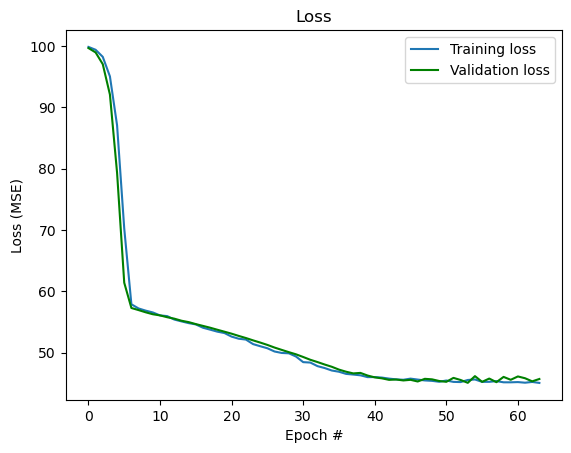

In [11]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MSE)')
plt.title('Loss')
plt.legend()
plt.show()

Na het trainen van het model en het plotten van de losses zien we dat er geen sprake is van overfitting, omdat de lijnen van de loss en de validation loss niet ver uit elkaar liggen. Wel valt het op dat de loss waardes vanaf ongeveer epoch 40 niet echt meer veranderen. We hebben geprobeerd met meerdere lagen te werken in ons model, andere aantal neuronen toe te passen, de optimizer aan te passen, maar alle methodes resulteren in de zelfde uitkomst. Ons fully-dense neuraal netwerk komt niet onder de 45% verschil met de werkelijke prijzen. Ook komen wij terug op onze keuze voor het aantal epochs. In het model is early stopping toegepast wat een model stopt, wanneer de loss niet veel meer verandert. Ons model is gestopt bij epoch 64 met een patience van 10 bij de early stopping. Hier stopt het model als de validation loss 10 keer achter elkaar niet meer daalt. 

In [12]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 2ms/step - loss: 50.7319


50.731910705566406

Om te kijken hoe gaat het model werkt op de testdata berekeken we ook hiervoor de loss en hier komen we uit op een loss van ongeveer 51% verschil met de werkelijke prijzen van de huizen. Aangezien er een hoop uitschieters waren, en de data niet heel veel correlerende kolommen had, zijn deze resultaten toch al redelijk goed voor ons eerste model.

[Back to the top](#start)
<a name='4.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H4: Convolutioneel neuraal netwerk</strong></h2>
</div>

In [21]:
num_samples = sum(1 for _ in final_dataset)
val_size = int(0.2 * num_samples) 

# Split the dataset into training and validation sets
val_dataset = final_dataset.take(val_size)
train_dataset = final_dataset.skip(val_size)

In [22]:
img_height, img_width = 256, 256
train_dataset = train_dataset.map(lambda x, y: (tf.image.resize(x, (img_height, img_width)), y))

In [23]:
val_dataset = val_dataset.map(lambda x, y: (tf.image.resize(x, (img_height, img_width)), y))

In [24]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(5).prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Hyperparameter tuner

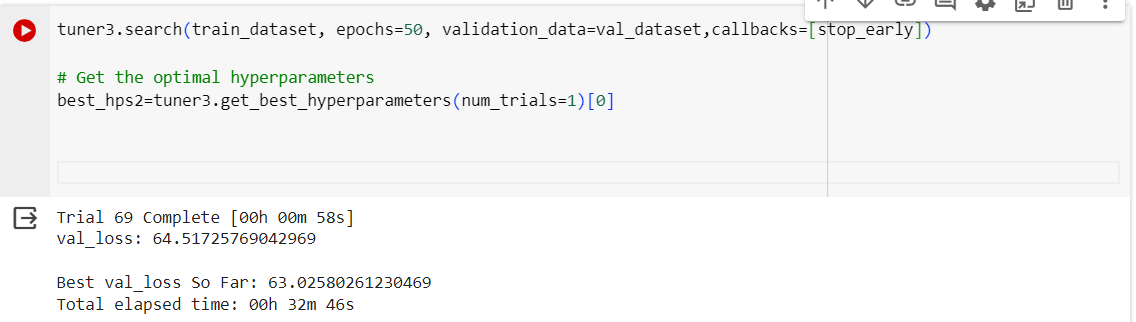

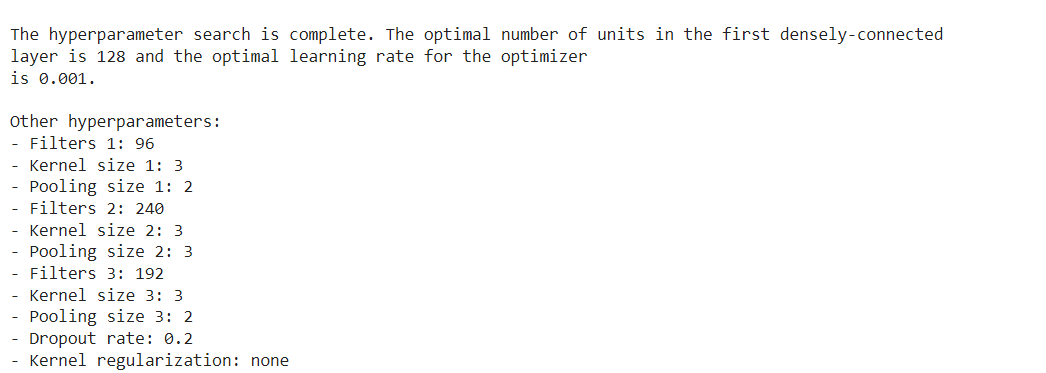

# Het model


In [ ]:
from keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

normalization_layer = tf.keras.layers.Rescaling(
    scale=1./255, offset=0.0)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)
cnn_model = tf.keras.Sequential([
    keras.Input(shape=((256,256,3))),
    normalization_layer,
    tf.keras.layers.Conv2D(96, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(240, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(3),
    tf.keras.layers.Conv2D(192, 3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [ ]:
tf.keras.utils.plot_model(cnn_model, to_file='jemoeder.png', show_shapes=True, show_layer_names=True)

In [ ]:
opt= keras.optimizers.Adam(learning_rate=0.0001)

cnn_model.compile(optimizer=opt,
              loss='mape')
cnn_history = cnn_model.fit(train_dataset, epochs=1000000, validation_data=val_dataset, callbacks=[stop_early])


[Back to the top](#start)
<a name='5.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H5: Transfer Learning</strong></h2>
</div>

<a name='5.1'></a>
<h2>&sect;5.1: Het model</h2>

In [69]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1)(x)

transfer_model = Model(inputs=base_model.input, outputs=predictions)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
transfer_model.compile(optimizer=opt, loss='mape')
history = transfer_model.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[stop_early])

Epoch 1/100
100/100 [==============================] - 25s 219ms/step - loss: 96.5767 - val_loss: 87.4018
Epoch 2/100
100/100 [==============================] - 18s 181ms/step - loss: 81.0070 - val_loss: 70.6324
Epoch 3/100
100/100 [==============================] - 19s 189ms/step - loss: 70.3631 - val_loss: 72.5801
Epoch 4/100
100/100 [==============================] - 19s 187ms/step - loss: 68.5883 - val_loss: 75.7166
Epoch 5/100
100/100 [==============================] - 19s 188ms/step - loss: 67.5930 - val_loss: 77.8499
Epoch 6/100
100/100 [==============================] - 19s 191ms/step - loss: 67.5589 - val_loss: 78.5080
Epoch 7/100
100/100 [==============================] - 19s 186ms/step - loss: 67.3231 - val_loss: 79.3554


In [71]:
base_model3 = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

for layer in base_model3.layers:
    layer.trainable = False

x = Flatten()(base_model3.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1)(x)

transfer_model3 = Model(inputs=base_model3.input, outputs=predictions)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
transfer_model3.compile(optimizer=opt, loss='mape')
history = transfer_model3.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[stop_early])

Epoch 1/100
100/100 [==============================] - 33s 281ms/step - loss: 82.0258 - val_loss: 74.8560
Epoch 2/100
100/100 [==============================] - 28s 279ms/step - loss: 77.1762 - val_loss: 70.0909
Epoch 3/100
100/100 [==============================] - 28s 281ms/step - loss: 74.9951 - val_loss: 79.1282
Epoch 4/100
100/100 [==============================] - 28s 283ms/step - loss: 76.3605 - val_loss: 69.5339
Epoch 5/100
100/100 [==============================] - 28s 282ms/step - loss: 70.2856 - val_loss: 79.6009
Epoch 6/100
100/100 [==============================] - 29s 286ms/step - loss: 75.6060 - val_loss: 83.9223
Epoch 7/100
100/100 [==============================] - 29s 286ms/step - loss: 72.3959 - val_loss: 83.6427
Epoch 8/100
100/100 [==============================] - 1300s 13s/step - loss: 84.4640 - val_loss: 73.5204
Epoch 9/100
100/100 [==============================] - 28s 278ms/step - loss: 71.7495 - val_loss: 74.6088


In [76]:
base_model4 = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

for layer in base_model4.layers:
    layer.trainable = False

x = Flatten()(base_model4.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(1)(x)

transfer_model4 = Model(inputs=base_model4.input, outputs=predictions)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
transfer_model4.compile(optimizer=opt, loss='mape')
history = transfer_model4.fit(train_dataset, epochs=100, validation_data=val_dataset, callbacks=[stop_early])

Epoch 1/100
100/100 [==============================] - 60s 523ms/step - loss: 85.8119 - val_loss: 73.8386
Epoch 2/100
100/100 [==============================] - 51s 506ms/step - loss: 67.7584 - val_loss: 82.9611
Epoch 3/100
100/100 [==============================] - 52s 521ms/step - loss: 67.6259 - val_loss: 85.1928
Epoch 4/100
100/100 [==============================] - 53s 535ms/step - loss: 67.6893 - val_loss: 85.8454
Epoch 5/100
100/100 [==============================] - 56s 562ms/step - loss: 67.1716 - val_loss: 85.1186
Epoch 6/100
100/100 [==============================] - 57s 569ms/step - loss: 66.7213 - val_loss: 84.9024


In [13]:
base_model5 = InceptionV3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
stop_early = EarlyStopping(monitor='val_loss', patience=5)

for layer in base_model5.layers:
    layer.trainable = False
    
x = Flatten()(base_model5.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1)(x)

transfer_model5 = Model(inputs=base_model5.input, outputs=predictions)

<a name='5.2'></a>
<h2>&sect;5.2: Modelarchitectuur</h2>

In [14]:
tf.keras.utils.plot_model(transfer_model5, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
transfer_model5.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mape')
history = transfer_model5.fit(train_dataset, epochs=100, validation_data=val_dataset, 
                              callbacks=[stop_early])

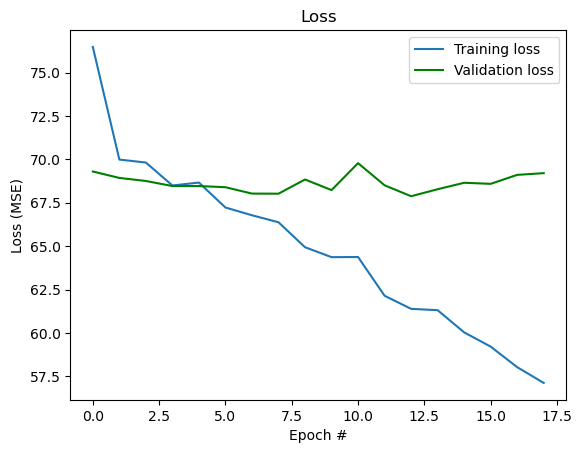

In [20]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], 'g', label='Validation loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss (MSE)')
plt.title('Loss')
plt.legend()
plt.show()

Het aantal epochs wat wij hebben gebruikt is weer af te leiden van de early stopping. Zo wordt het model getraind met 100 epochs, maar zal het model stoppen op het moment dat de validation loss 5 keer achter elkaar niet meer naar beneden gaat. Dit gebeurt op epoch 64 en daarom kiezen we er voor om het model te gebruiken op 64 epochs.

<a name='5.3'></a>
<h2>&sect;5.3: Naam van de modelarchitectuur en de dataset</h2>

<a name='5.4'></a>
<h2>&sect;5.4: Voordelen vooraf getrainde visionmodellen</h2>

<a name='5.5'></a>
<h2>&sect;5.5: Stappen finetunen vooraf getraind model</h2>

<a name='5.6'></a>
<h2>&sect;5.6: Als regularisatie, data augmentation, finetuning is plaatsgevonden, leg uit waarom.</h2>

[Back to the top](#start)
<a name='6.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H6: Multimodaal model</strong></h2>
</div>

[Back to the top](#start)
<a name='7.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H7: Bevindingen</strong></h2>
</div>

<a name='7.1'></a>
<h2>&sect;7.1: Samenvatting uitkomsten</h2>

##### Geef een beknopt overzicht van de resultaten

##### Welk model presteert het beste? Met welke parameters?

##### Toon je scores op Kaggle en laat zien wat de resultaten waren van je verbeteringen op Kaggle.

[Back to the top](#start)
<a name='8.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H8: Conslusie en aanbevelingen</strong></h2>
</div>

<a name='8.1'></a>
<h2>&sect;8.1: Uitdagingen modelleringsproces</h2>

<a name='8.2'></a>
<h2>&sect;8.2: Prestaties modelarchitecturen</h2>

<a name='8.3'></a>
<h2>&sect;8.3: Advies aan makelaar</h2>

<a name='8.4'></a>
<h2>&sect;8.4: Advies huizen(ver)koper</h2>

[Back to the top](#start)
<a name='9.0'></a>

<div style="background-color:#345783; text-align:center; vertical-align:middle; padding:10px 0; margin-top:5px; margin-bottom:5px">
        <h2 style="color:white"><strong>H9: Literatuurlijst</strong></h2>
</div>

Fully dense neural network:
- Brownlee, J. (2020, 20 augustus). A Gentle Introduction to the Rectified Linear Unit (ReLU). MachineLearningMastery.com. https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/
- Online, S. (2023, 16 november). Adam Optimizer for Stochastic Gradient Descent - Shiksha Online. Shiksha.com. https://www.shiksha.com/online-courses/articles/adam-optimizer-for-stochastic-gradient-descent/#What-is-Adam-Optimizer?-